## 1. Libraries

In [ ]:
# Note: adding datasets folder to 'My Drive' is required!
# This defines file paths
ROOT = './datasets'
FAKE_OR_REAL = ROOT + '/fake_or_real_news/fake_or_real_news.csv'
LIAR_LIAR_TRAIN = ROOT + '/liar/train.tsv'
LIAR_LIAR_TEST = ROOT + '/liar/test.tsv'

In [3]:
# Import libraries
import nltk
import pandas as pd
import numpy as np
import math
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# Setup matplotlib
%matplotlib inline


## 2. Datasets
### 2.1. 'Liar Liar' dataset

In [5]:
# Import 'Liar Liar' dataset
# Note: the dataset has already been splitted in train and test dataset
liar_ds_train = pd.read_csv(LIAR_LIAR_TRAIN, delimiter='\t', header=None)
liar_ds_test = pd.read_csv(LIAR_LIAR_TEST, delimiter='\t', header=None)

In [6]:
# Retrieve text (X) and label (Y) columns
# Only 'true' and 'false' values
# Only text (index=1) and labels (index=2) are mantained

# Train dataset
liar_ds_train = liar_ds_train.loc[liar_ds_train[1].isin(['true', 'false']), 1:2]
# Test dataset
liar_ds_test = liar_ds_test.loc[liar_ds_test[1].isin(['true', 'false']), 1:2]

In [7]:
# Check train dataset
liar_ds_train.head()

,1,2
0,false,Says the Annies List political group supports ...
3,false,Health care reform legislation is likely to ma...
5,true,The Chicago Bears have had more starting quart...
12,false,When Mitt Romney was governor of Massachusetts...
16,true,McCain opposed a requirement that the governme...


In [8]:
# Check test dataset
liar_ds_test.head()

,1,2
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
5,true,Over the past five years the federal governmen...
6,true,Says that Tennessee law requires that schools ...


In [9]:
# Define X (inputctext ) and Y (label) variables for each dataset

# Train dataset
X_train_liar = liar_ds_train[2]
Y_train_liar = liar_ds_train[1]
# Test dataset
X_test_liar = liar_ds_test[2]
Y_test_liar = liar_ds_test[1]

In [10]:
# Labels falues must be turned into 0|1 form 'false'|'true'
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(['false', 'true'])
# Encode labels
Y_train_liar = le.transform(Y_train_liar)
Y_test_liar = le.transform(Y_test_liar)

<BarContainer object of 2 artists>

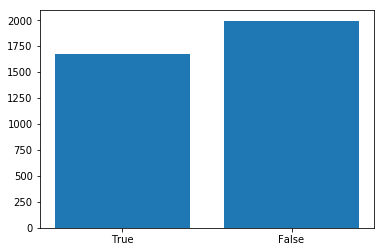

In [11]:
# Show training dataset Y labels distribution
plt.bar(['True', 'False'], [len([y for y in Y_train_liar if y]), len([y for y in Y_train_liar if not y])])

<BarContainer object of 2 artists>

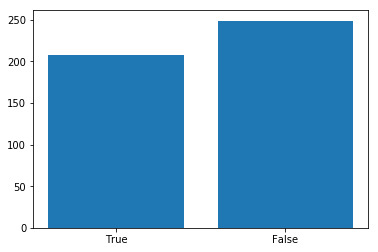

In [12]:
# Show testing dataset Y labels distribution
plt.bar(['True', 'False'], [len([y for y in Y_test_liar if y]), len([y for y in Y_test_liar if not y])])

### 2.2 'Fake or Real' dataset

In [13]:
# Import 'Fake or Real' dataset
fake_or_real = pd.read_csv(FAKE_OR_REAL, delimiter=',', header=0)

In [14]:
# Define X (input text) and Y (label) variables

X_fake_or_real = fake_or_real['text']
Y_fake_or_real = fake_or_real['label']

In [18]:
# Encode the label from 'FAKE'|'REAL' to 0|1
from sklearn.preprocessing import LabelEncoder

Y_fake_or_real = LabelEncoder().fit(['FAKE', 'REAL']).transform(Y_fake_or_real)

C:\Users\micha\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


ValueError: y contains new labels: [0 1]

<BarContainer object of 2 artists>

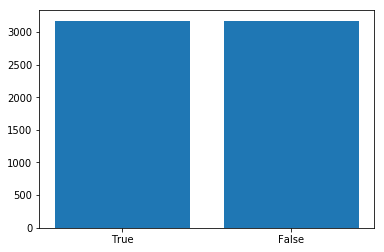

In [19]:
# Show dataset Y labels distribution
plt.bar(['True', 'False'], [len([y for y in Y_fake_or_real if y]), len([y for y in Y_fake_or_real if not y])])

In [20]:
# Split dataset into training and testing
from sklearn.model_selection import train_test_split

X_train_fake_or_real, X_test_fake_or_real, Y_train_fake_or_real, Y_test_fake_or_real = train_test_split(
    X_fake_or_real, Y_fake_or_real, test_size = 0.2, random_state = 0
)

<BarContainer object of 2 artists>

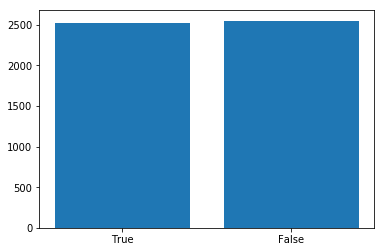

In [21]:
# Show train dataset Y labels distribution
plt.bar(['True', 'False'], [len([y for y in Y_train_fake_or_real if y]), len([y for y in Y_train_fake_or_real if not y])])

<BarContainer object of 2 artists>

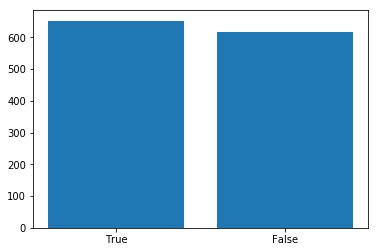

In [22]:
# Show test dataset Y labels distribution
plt.bar(['True', 'False'], [len([y for y in Y_test_fake_or_real if y]), len([y for y in Y_test_fake_or_real if not y])])

## 3. Feature extraction

### Bag of Words


In [23]:
# Import CountVectorizer: an object which handles BOW automatically
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# Get few rows of liar dataset (just to show bag of words)
X_train = X_train_liar[0:2]
Y_train = Y_train_liar[0:2]

In [ ]:
# Compute BOW
cv = CountVectorizer().fit(X_train, Y_train)
# Vectorize rows
X_train = cv.transform(X_train)
# Show first row vectorized
X_train_array = X_train.toarray()

In [41]:
#lets extract some basic BOW default features for both our datasets
from sklearn.feature_extraction.text import CountVectorizer
cv1=CountVectorizer()
#liar liar dataset
X_train_liar_c=cv1.fit_transform(X_train_liar)
X_test_liar_c=cv1.fit_transform(X_test_liar)
#fake or real dataset
X_train_fake_or_real_c=cv1.fit_transform(X_train_fake_or_real)
X_test_fake_or_real_c=cv1.fit_transform(X_test_fake_or_real)

## 4. Feature selection
### PCA
Principal Component Analysis seems to be not helpful. As we see from the graph, where the red line shows cumulated explained variance and blue line represents explained variance for each specific parameter - in the case of Bag of Words each of the principal components contributes to the variance explanation almost equally for both of datasets. We will use Chi-squared feature selection then.

In [28]:
from sklearn.decomposition import PCA

In [29]:
# Definition of a function which changes CountVectorizer into DataFrame
def vectorizer(v, x):
    return pd.DataFrame(
        v.fit_transform(x).toarray(),
        columns=v.get_feature_names()
        
    )

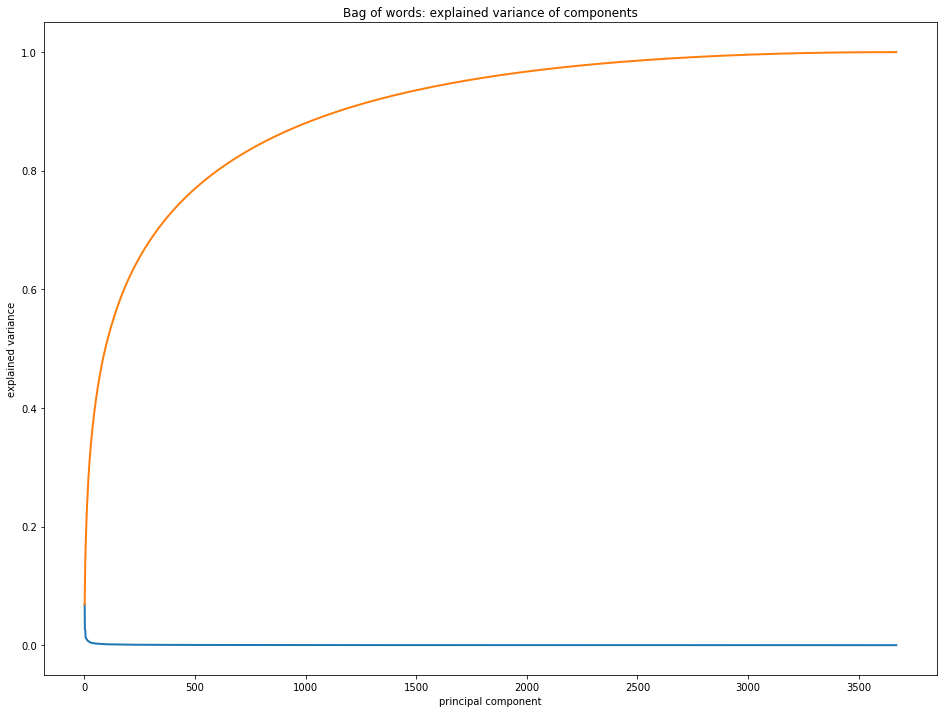

In [31]:
# PCA for Bag of Words approach for Liar Liar dataset
cv_pca_bow = vectorizer(cv1, X_train_liar)
pca = PCA(n_components=3670).fit(cv_pca_bow)

fig, ax = plt.subplots(figsize=(16,12))
x_values = range(1, pca.n_components_+1)
ax.plot(x_values, pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Bag of words: explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

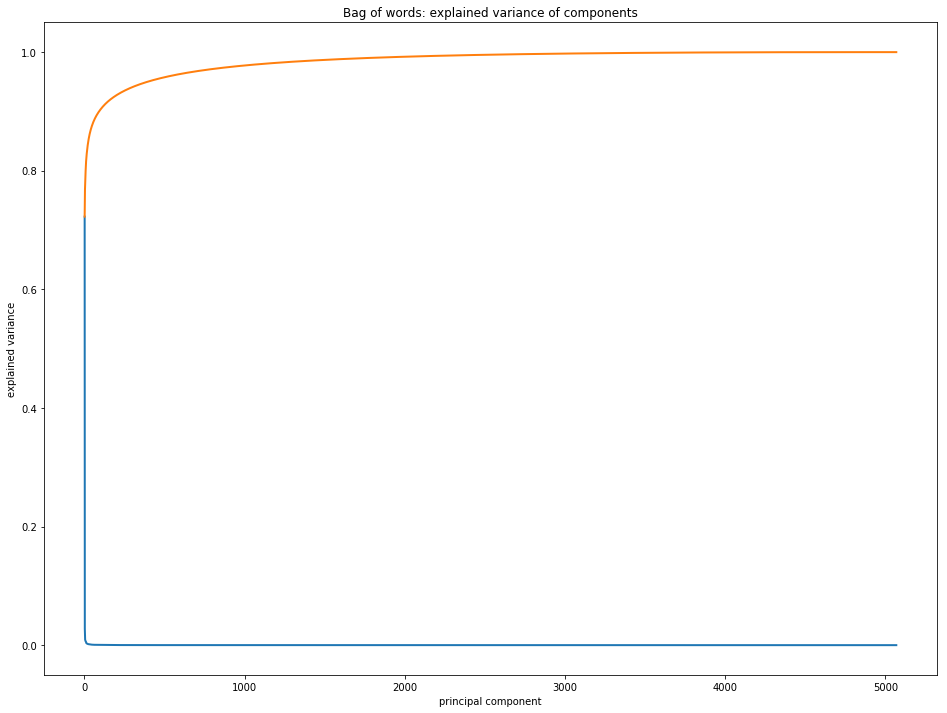

In [44]:
# PCA for Bag of Words approach for 'fake or real' dataset
cv_pca_bow = vectorizer(cv1, X_train_fake_or_real)
pca = PCA(n_components=5068).fit(cv_pca_bow)

fig, ax = plt.subplots(figsize=(16,12))
x_values = range(1, pca.n_components_+1)
ax.plot(x_values, pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Bag of words: explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

## 5. Model
### Multinomial Naive Bayes

For the 'liar, liar' dataset (with Bag of Words and Chi-squared feature selection)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb = Pipeline([('vect', CountVectorizer()),
               ('chi2', SelectKBest(chi2, k=200)),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train_liar, Y_train_liar)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test_liar)

print('accuracy %s' % accuracy_score(y_pred, Y_test_liar))
print(classification_report(Y_test_liar, y_pred))

accuracy 0.6280087527352297
             precision    recall  f1-score   support

          0       0.65      0.69      0.67       249
          1       0.60      0.55      0.57       208

avg / total       0.63      0.63      0.63       457



For the 'fake or real' dataset (with Bag of Words and Chi-squared feature selection)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb = Pipeline([('vect', CountVectorizer()),
               ('chi2', SelectKBest(chi2, k=200)),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train_fake_or_real, Y_train_fake_or_real)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test_fake_or_real)

print('accuracy %s' % accuracy_score(y_pred, Y_test_fake_or_real))
print(classification_report(Y_test_fake_or_real, y_pred))

accuracy 0.8074191002367798
             precision    recall  f1-score   support

          0       0.79      0.83      0.81       615
          1       0.83      0.79      0.81       652

avg / total       0.81      0.81      0.81      1267

